This notebook includes the whole precedure building a logistic regression model, including:
### Step 1: Basic observations on the dataset
### Step 2: Split into training and testing datasets
- To avoid the individual bias and avoid the feature leakage, we randomly split videos into the training(80%) and testing dataset(20%)
  - We shuffle and randomly split the videos until the percentage of the paired investigation is comparable in both datasets
- To avoid order bias, we shuffle all investigation bouts within each dataset
- To avoid scaling bias, we apply Min-Max normalization on the training set and use the same transformation on the test set

### Step 3: Apply logistic regression
- Fit the model with L2 regularization to prevent overfitting
- Perform grid search over penalty values (10⁻⁴ to 10⁴) using mean 3-fold cross-validated accuracy for model selection

### Step 4: Evaluate the model
- Accuracy score: Proportion of correct predictions on the test set
- Cross-validation: 3-fold
- F1 score: To account for class imbalance

| Loading modules 

In [41]:
#import the neccessary python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
#import some useful functions from sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import mglearn

#import some plotting packages
import seaborn as sns

#statistic comparison method
#because in our dataset, paired and non-paired investigations might be from the same video sequence, 
#we use the mixed effects model to do the statistic test in these two groups, using sequence_code as a fixed effect
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp

### Step 1: Basic observations on the dataset


1 | Load the preprocessed dat with hand-crafted features

,sequence,investigation_ID,pair_label,paired,start_frame,end_frame,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
0,task1/train/mouse001_task1_annotator1,0,0_0,0,1,126,126,6.619949,3.681024,2.861946,0.047836
1,task1/train/mouse001_task1_annotator1,1,1_0,0,136,633,498,6.364444,3.583990,2.924218,0.041316
2,task1/train/mouse001_task1_annotator1,2,2_0,0,659,714,56,9.422267,5.151395,2.938320,0.045286
3,task1/train/mouse001_task1_annotator1,3,3_0,0,736,898,163,4.820933,3.456058,3.002670,0.039957
4,task1/train/mouse001_task1_annotator1,4,4_0,0,944,1045,102,2.838757,2.808712,2.714141,0.036523


,investigation_ID,paired,start_frame,end_frame,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
count,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000,2879.000000
mean,29.082668,0.138590,6273.171587,6344.380688,72.209100,7.162941,4.765183,2.899996,0.053228
std,28.126639,0.345578,5144.694386,5132.128523,121.178995,4.923105,5.019670,0.134659,0.034554
min,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000,2.020127,0.000000
25%,8.000000,0.000000,2023.000000,2089.000000,14.000000,4.040029,3.032544,2.841902,0.035343
50%,20.000000,0.000000,4972.000000,5037.000000,30.000000,6.041922,4.023517,2.925928,0.046019
75%,42.000000,0.000000,9629.500000,9698.500000,71.500000,8.935472,5.381169,2.994524,0.060868
max,155.000000,1.000000,23128.000000,23176.000000,1335.000000,110.985818,218.968631,3.136071,0.737952


sequence               0
investigation_ID       0
pair_label             0
paired                 0
start_frame            0
end_frame              0
duration               0
mean_speed             0
mean_acc               0
mean_rotation          0
mean_rotation_speed    0
dtype: int64


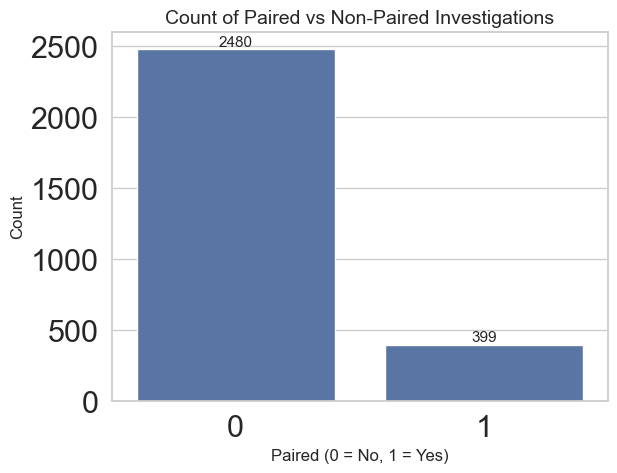

In [42]:
# Load your dataset (adjust path as needed)
df = pd.read_csv(r"G:\My Drive\100-PhD Study\110-Courses\2025Summer_Neuromatch\waffles\Waffle\preprocessed_data\final_df.csv")  # or df = your_dataframe

# Preview data
display(df.head())

# Summary statistics
display(df.describe())

# Check for missing values, just to make sure there's no missing data
print(df.isnull().sum())

# Show a bar plot reflecting the total number of 'paired investigation(1)' VS 'unpaired investigation(0)'
sns.countplot(data=df, x='paired')  
plt.title("Count of Paired vs Non-Paired Investigations", fontsize=14)
plt.xlabel("Paired (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Annotate the bars with counts
counts = df['paired'].value_counts().sort_index()
for i, count in enumerate(counts):
    plt.text(i, count + 2, str(count), ha='center', va='bottom', fontsize=11)

plt.show()




##### We extracted 2879 investigation bouts from 88 videos, and (399/2879)13.9% of them are paired with a followed attack, which means the this is an imbalanced dataset with most investigations not immediately followed by an attack.

### Step 2: Split into training and testing datasets
1. GroupShuffleSplit the videos into the training(80%) and testing(20%) 
2. Shuffle the investigation bouts within a trianing set to avoid the order bias

In [43]:
print("Number of unique sequences:", df['sequence'].unique())
#note that 'task1/train/mouse036_task1_annotator1' was dropped after runnning find_I_A_all function the the preprecessed_label_feature notebook

Number of unique sequences: ['task1/train/mouse001_task1_annotator1'
 'task1/train/mouse002_task1_annotator1'
 'task1/train/mouse003_task1_annotator1'
 'task1/train/mouse004_task1_annotator1'
 'task1/train/mouse005_task1_annotator1'
 'task1/train/mouse006_task1_annotator1'
 'task1/train/mouse007_task1_annotator1'
 'task1/train/mouse008_task1_annotator1'
 'task1/train/mouse009_task1_annotator1'
 'task1/train/mouse010_task1_annotator1'
 'task1/train/mouse011_task1_annotator1'
 'task1/train/mouse012_task1_annotator1'
 'task1/train/mouse013_task1_annotator1'
 'task1/train/mouse014_task1_annotator1'
 'task1/train/mouse015_task1_annotator1'
 'task1/train/mouse016_task1_annotator1'
 'task1/train/mouse017_task1_annotator1'
 'task1/train/mouse018_task1_annotator1'
 'task1/train/mouse019_task1_annotator1'
 'task1/train/mouse020_task1_annotator1'
 'task1/train/mouse021_task1_annotator1'
 'task1/train/mouse022_task1_annotator1'
 'task1/train/mouse023_task1_annotator1'
 'task1/train/mouse024_task1_

In [5]:
#reencode the video ID to numbers
# Encode 'sequence' into numeric form 
df['sequence_code'] = pd.factorize(df['sequence'])[0]  # or 'video_id'


In [6]:
#drop the non-numeric information
non_numeric =['sequence', 'pair_label','start_frame','end_frame']
df_dropped = df.copy(deep=True)
df_dropped = df_dropped.drop(columns=non_numeric)

In [7]:
df_dropped

,investigation_ID,paired,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed,sequence_code
0,0,0,126,6.619949,3.681024,2.861946,0.047836,0
1,1,0,498,6.364444,3.583990,2.924218,0.041316,0
2,2,0,56,9.422267,5.151395,2.938320,0.045286,0
3,3,0,163,4.820933,3.456058,3.002670,0.039957,0
4,4,0,102,2.838757,2.808712,2.714141,0.036523,0
...,...,...,...,...,...,...,...,...
2874,42,0,6,2.615893,3.908312,3.126484,0.009456,87
2875,43,0,8,3.931406,2.945635,2.808574,0.045937,87
2876,44,0,13,1.449746,1.718144,2.936758,0.031133,87
2877,45,0,144,2.105103,2.130460,3.040754,0.018255,87


In [44]:
#try to write a function to split the dataset until the bouts and paired investigation percentage is similar in the trainig and testing dataset
best_diff = float('inf')
best_split = None

groups = df_dropped['sequence_code']  # 
labels = df_dropped['paired'].values

#search for a seed that result a comparable percentage of paired investigation in both datasets
for seed in range(1000):
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=seed) #group shuffle split by the video sequence
    train_idx, test_idx = next(gss.split(df_dropped, labels, groups=groups))
    
    y_train = labels[train_idx]
    y_test = labels[test_idx]
    
    train_pct = y_train.mean()
    test_pct = y_test.mean()
    
    diff = abs(train_pct - test_pct)
    
    if diff < best_diff:
        best_diff = diff
        best_split = (train_idx, test_idx)
        
    if diff < 0.01:  # stop early if sufficiently close
        break

train_idx, test_idx = best_split
df_train = df_dropped.iloc[train_idx].reset_index(drop=True)
df_test = df_dropped.iloc[test_idx].reset_index(drop=True)


In [45]:
print("random seed is: ",seed)

random seed is:  7


| Shuffle the investigation bouts within each dataset

In [46]:
#shuffle bouts in trianig set to avoid the order bias
df_train = df_train.sample(frac=1, random_state=42).reset_index()
x_train = df_train.drop(columns=['paired'])
y_train = df_train['paired']
#same shuffle in the testing dataset to void the order bias
df_test = df_test.sample(frac=1,random_state=42).reset_index()
x_test = df_test.drop(columns=['paired'])
y_test = df_test['paired']

| Check the training and testing datasets

1. check if the counts of the investigations from the same video are comparable

In [47]:
#show the counts of investigations from the same vdeo is comparable
x_train_counts = x_train.groupby('sequence_code').count()
x_test_counts = x_test.groupby('sequence_code').count() 

In [48]:
x_train_counts

,index,investigation_ID,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed
sequence_code,,,,,,,
0,58,58,58,58,58,58,58
1,123,123,123,123,123,123,123
3,22,22,22,22,22,22,22
4,15,15,15,15,15,15,15
5,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...
83,47,47,47,47,47,47,47
84,20,20,20,20,20,20,20
85,39,39,39,39,39,39,39


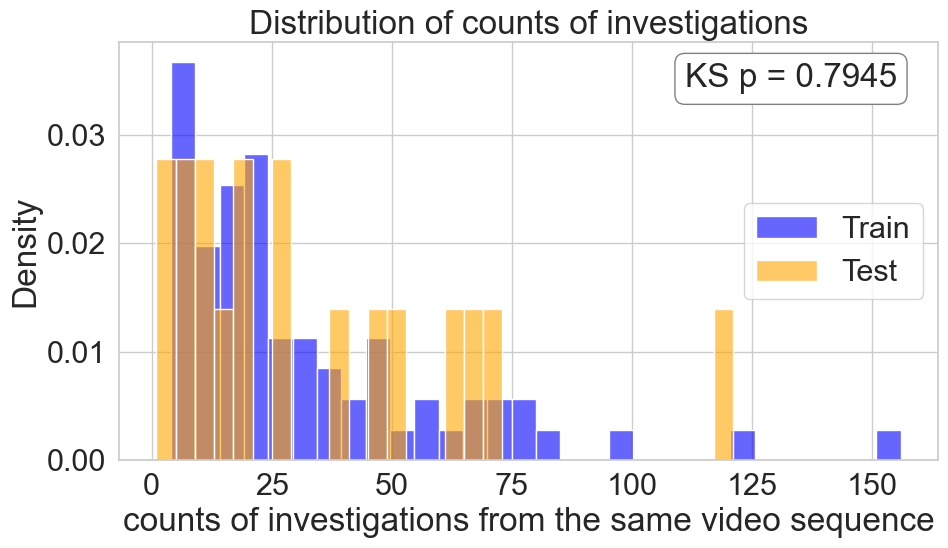

In [49]:
plt.figure(figsize=(10, 6))
sns.histplot(x_train_counts['investigation_ID'], color='blue', label='Train', bins=30, kde=False, stat='density', alpha=0.6)
sns.histplot(x_test_counts['investigation_ID'], color='orange', label='Test', bins=30, kde=False, stat='density', alpha=0.6)

# KS test
ks_stat, ks_p = ks_2samp(x_train_counts['investigation_ID'], x_test_counts['investigation_ID'])

# Annotate
plt.text(0.95, 0.95, f"KS p = {ks_p:.4f}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.title("Distribution of counts of investigations")
plt.xlabel("counts of investigations from the same video sequence")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


2. check if ther percentage of paired investigations are comparable 

C:\Users\sky\AppData\Local\Temp\ipykernel_30464\3036740146.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=bouts_vals, palette=colors, ax=ax[0])
C:\Users\sky\AppData\Local\Temp\ipykernel_30464\3036740146.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=paired_pct_vals, palette=colors, ax=ax[1])


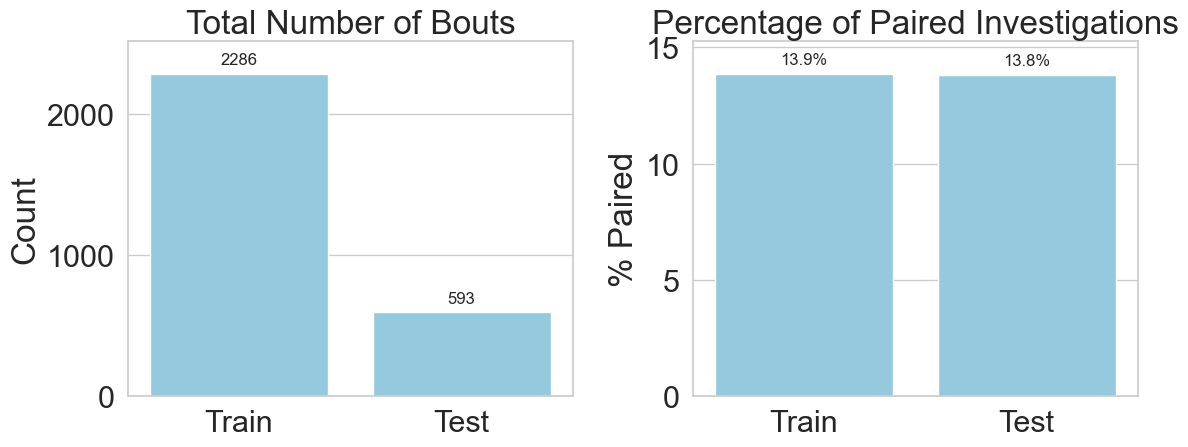

In [50]:

# Data
n_train = len(df_train)
n_test = len(df_test)

train_paired = df_train['paired'].sum()
test_paired = df_test['paired'].sum()

train_paired_pct = train_paired / n_train * 100
test_paired_pct = test_paired / n_test * 100

# --- Plot ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
colors = ['skyblue', 'skyblue']

# 1. Total number of bouts
bouts_vals = [n_train, n_test]
sns.barplot(x=['Train', 'Test'], y=bouts_vals, palette=colors, ax=ax[0])
ax[0].set_title('Total Number of Bouts')
ax[0].set_ylabel('Count')

# Add value labels and adjust y-limit
max_bouts = max(bouts_vals)
for i, val in enumerate(bouts_vals):
    ax[0].text(i, val + max_bouts * 0.02, f'{val}', ha='center', va='bottom', fontsize=12)
ax[0].set_ylim(0, max_bouts * 1.10)

# 2. Percentage of paired investigations
paired_pct_vals = [train_paired_pct, test_paired_pct]
sns.barplot(x=['Train', 'Test'], y=paired_pct_vals, palette=colors, ax=ax[1])
ax[1].set_title('Percentage of Paired Investigations')
ax[1].set_ylabel('% Paired')

max_pct = max(paired_pct_vals)
for i, val in enumerate(paired_pct_vals):
    ax[1].text(i, val + max_pct * 0.02, f'{val:.1f}%', ha='center', va='bottom', fontsize=12)
ax[1].set_ylim(0, max_pct * 1.10)

plt.tight_layout()
plt.show()


(Checking point) Check the distribution and correlation of features

| plot the scatter_matrix to :
1. Visualize pairwise relationships between all features
2. Check correlations or patterns among features
3. Spot outliers or clusters
4. Use color (c) to reflect class labels, e.g. y_train

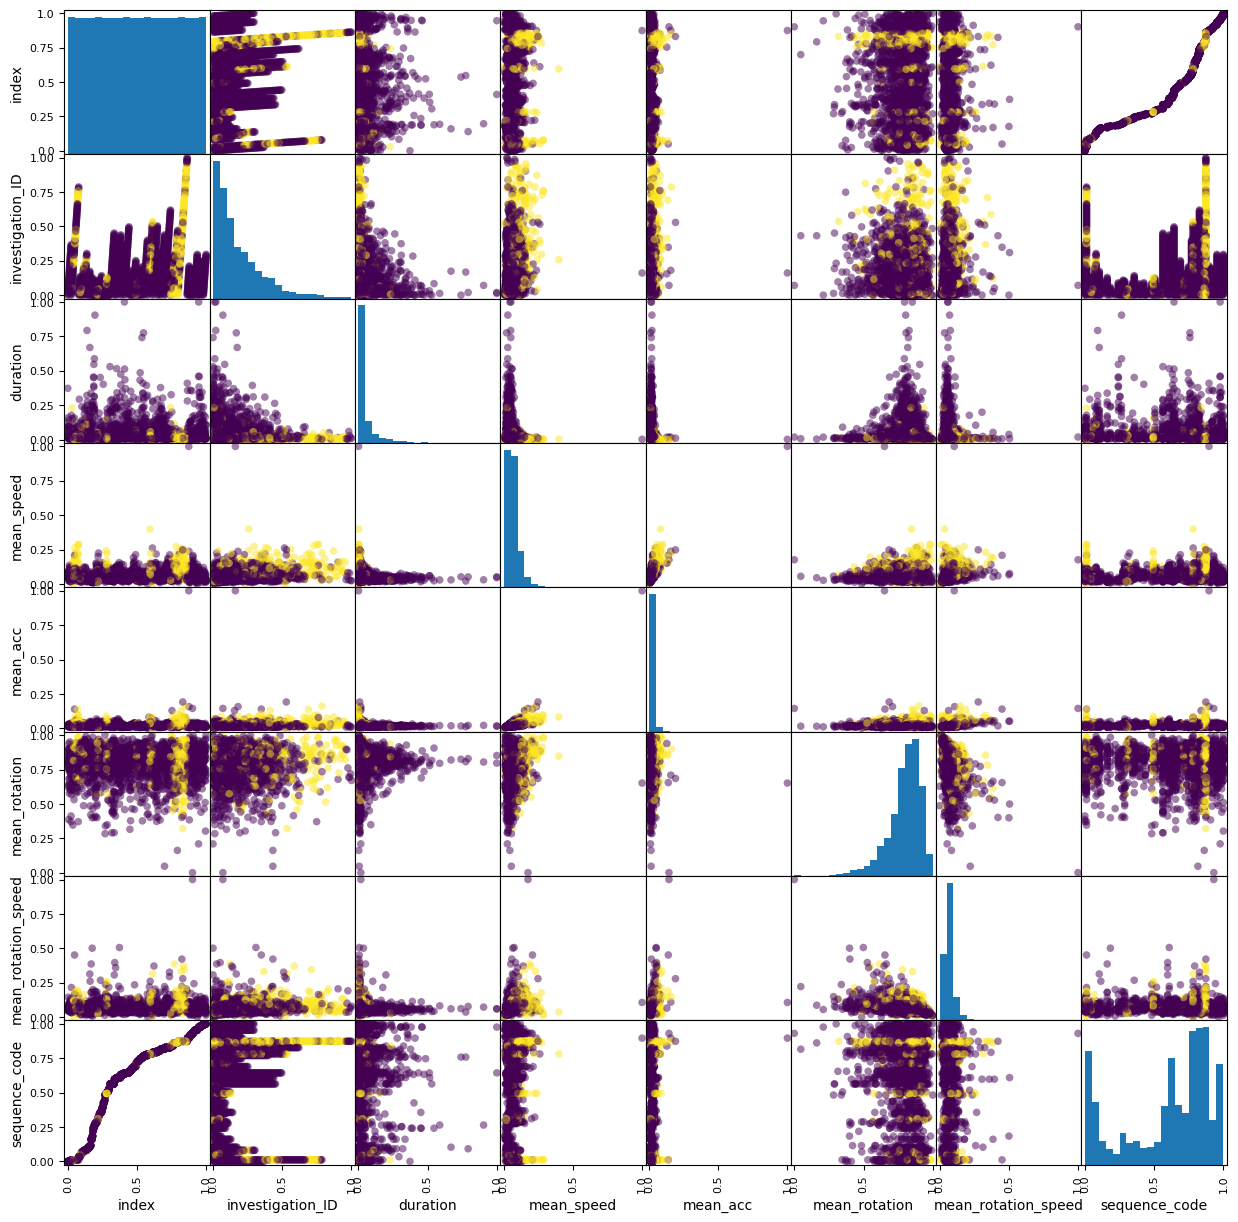

In [13]:
#check the correlation between each features, the distribution of the non-related features like the 
#sequence_code and investigation_ID should be random
grr = pd.plotting.scatter_matrix(x_train_scaled,c=y_train,figsize=(15,15),marker='o',hist_kwds={'bins':20},s=30,alpha=.5)


In [ ]:
x_train.corr(numeric_only=True)

,index,investigation_ID,duration,mean_speed,mean_acc,mean_rotation,mean_rotation_speed,sequence_code
index,1.000000,0.171020,-0.042675,0.131704,0.058731,-0.019552,0.031276,0.947659
investigation_ID,0.171020,1.000000,-0.193516,0.249016,0.119912,-0.057150,0.112719,0.110271
duration,-0.042675,-0.193516,1.000000,-0.229481,-0.096944,0.052493,-0.110032,-0.015923
mean_speed,0.131704,0.249016,-0.229481,1.000000,0.726016,0.030019,0.294565,0.103679
mean_acc,0.058731,0.119912,-0.096944,0.726016,1.000000,-0.026089,0.314993,0.036050
mean_rotation,-0.019552,-0.057150,0.052493,0.030019,-0.026089,1.000000,-0.404900,-0.028105
mean_rotation_speed,0.031276,0.112719,-0.110032,0.294565,0.314993,-0.404900,1.000000,0.021131
sequence_code,0.947659,0.110271,-0.015923,0.103679,0.036050,-0.028105,0.021131,1.000000


combined with the correlation calculation, we found that mean speed and mean acceleration has 0.726016 correlation, other features are mostly weakly correlated

In [15]:
#merge the traininig dataset with label for violin plotting
x_train_violin = x_train_scaled.copy(deep=True)
x_train_violin["paired"] = y_train.values
x_test_violin = x_test_scaled.copy(deep=True)
x_test_violin["paired"] = y_test.values

#do the 

#violin plot for features by paired investigation VS non-paired investigation
features = ["duration","mean_speed","mean_acc","mean_rotation","mean_rotation_speed"]

| Check whether features are significantly different in paired VS non-paired investigations, and check whether the trend is preserved in both the training and testing datasets

In [16]:
#do the mixed effect test
mixed_results = {}
for feature in features:
    model_df = x_train_violin[[feature,'paired','sequence_code']].dropna()
    model_df['paired'] = model_df['paired'].astype('category')
    
    try:
        model = smf.mixedlm(f"{feature}~paired", model_df, groups=model_df["sequence_code"])
        result = model.fit()
        #T.1 mean "this is the treatment level corresponding to paired=1", so we view non-paired as the reference or basline
        pval = result.pvalues.get('paired[T.1]',None) #extract p for paired=1
        mixed_results[feature] = {
            'model':'feature ~ paired + (1 | sequence_code)',
            'pval':pval
        }
    except Exception as e:
        print(f'Could not fit model for {feature}: {e}')
        mixed_results[feature]={
            'model':'model failed',
            'pval': None
        }

c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: Convergence

In [17]:
mixed_results

{'duration': {'model': 'feature ~ paired + (1 | sequence_code)',
  'pval': 0.13950846694209826},
 'mean_speed': {'model': 'feature ~ paired + (1 | sequence_code)',
  'pval': 7.074007904117232e-35},
 'mean_acc': {'model': 'feature ~ paired + (1 | sequence_code)',
  'pval': 1.0306356489252095e-11},
 'mean_rotation': {'model': 'feature ~ paired + (1 | sequence_code)',
  'pval': 0.0008798121862201229},
 'mean_rotation_speed': {'model': 'feature ~ paired + (1 | sequence_code)',
  'pval': 0.00020776016395792428}}

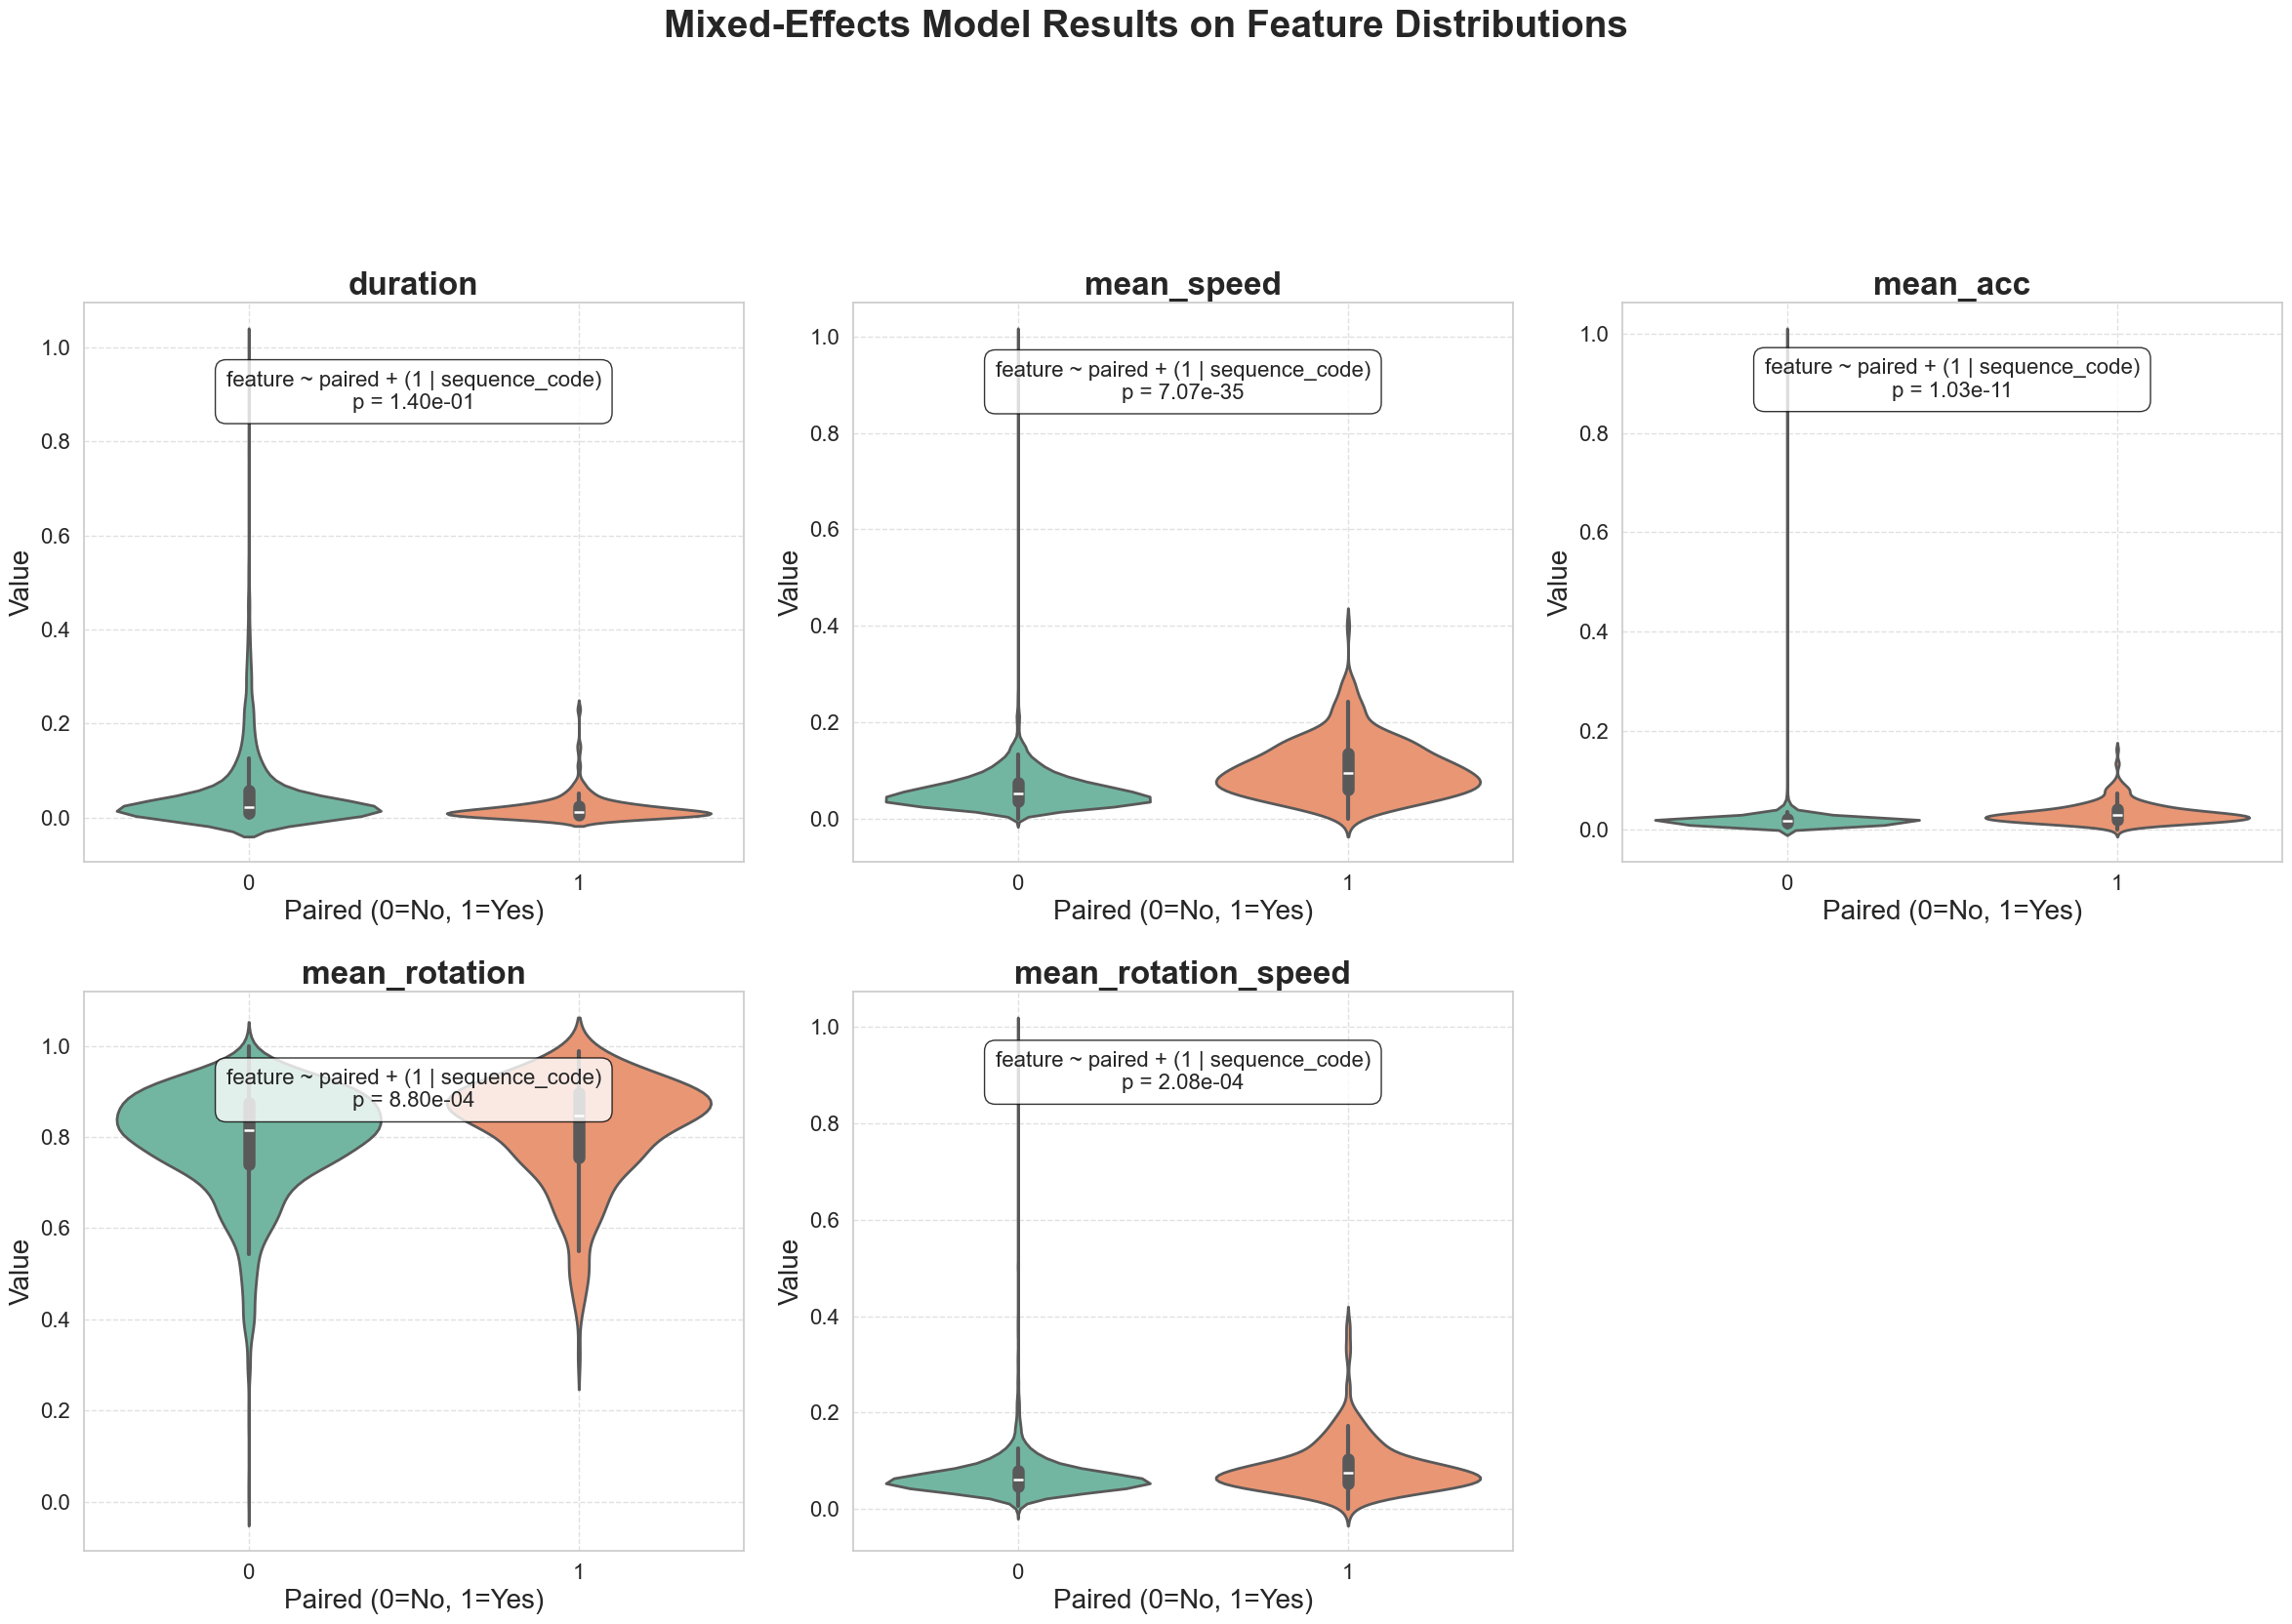

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style and font scale for big presentations
sns.set(style="whitegrid", font_scale=2)

# Initialize figure with large size
plt.figure(figsize=(24, 16))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)

    # Draw violin plot with hue to avoid deprecation warning
    sns.violinplot(
        data=x_train_violin,
        x='paired',
        y=feature,
        hue='paired',
        palette='Set2',
        density_norm='width',
        inner='box',
        linewidth=2,
        legend=False
    )

    # Set titles and labels in large fonts
    plt.title(f'{feature}', fontsize=24, fontweight='bold')
    plt.xlabel('Paired (0=No, 1=Yes)', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add model annotation with larger font
    model_info = mixed_results.get(feature, {})
    model_text = model_info.get('model', 'model failed')
    pval = model_info.get('pval', None)
    annotation = f'{model_text}\np = {pval:.2e}' if pval is not None else f'{model_text}\np = N/A'

    # Put annotation slightly above max y
    y_max = x_train_violin[feature].max()
    plt.text(
        0.5,
        y_max * 0.95,
        annotation,
        ha='center',
        va='top',
        fontsize=16,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5')
    )

# Super title
plt.suptitle('Mixed-Effects Model Results on Feature Distributions', fontsize=28, fontweight='bold', y=1.05)

# Fix layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [19]:
# do the same test for the test dataset
#do the mixed effect test
mixed_results = {}
for feature in features:
    model_df = x_test_violin[[feature,'paired','sequence_code']].dropna()
    model_df['paired'] = model_df['paired'].astype('category')
    
    try:
        model = smf.mixedlm(f"{feature}~paired", model_df, groups=model_df["sequence_code"])
        result = model.fit()
        #T.1 mean "this is the treatment level corresponding to paired=1", so we view non-paired as the reference or basline
        pval = result.pvalues.get('paired[T.1]',None) #extract p for paired=1
        mixed_results[feature] = {
            'model':'feature ~ paired + (1 | sequence_code)',
            'pval':pval
        }
    except Exception as e:
        print(f'Could not fit model for {feature}: {e}')
        mixed_results[feature]={
            'model':'model failed',
            'pval': None
        }

c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\sky\anaconda3\envs\waffles\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fa

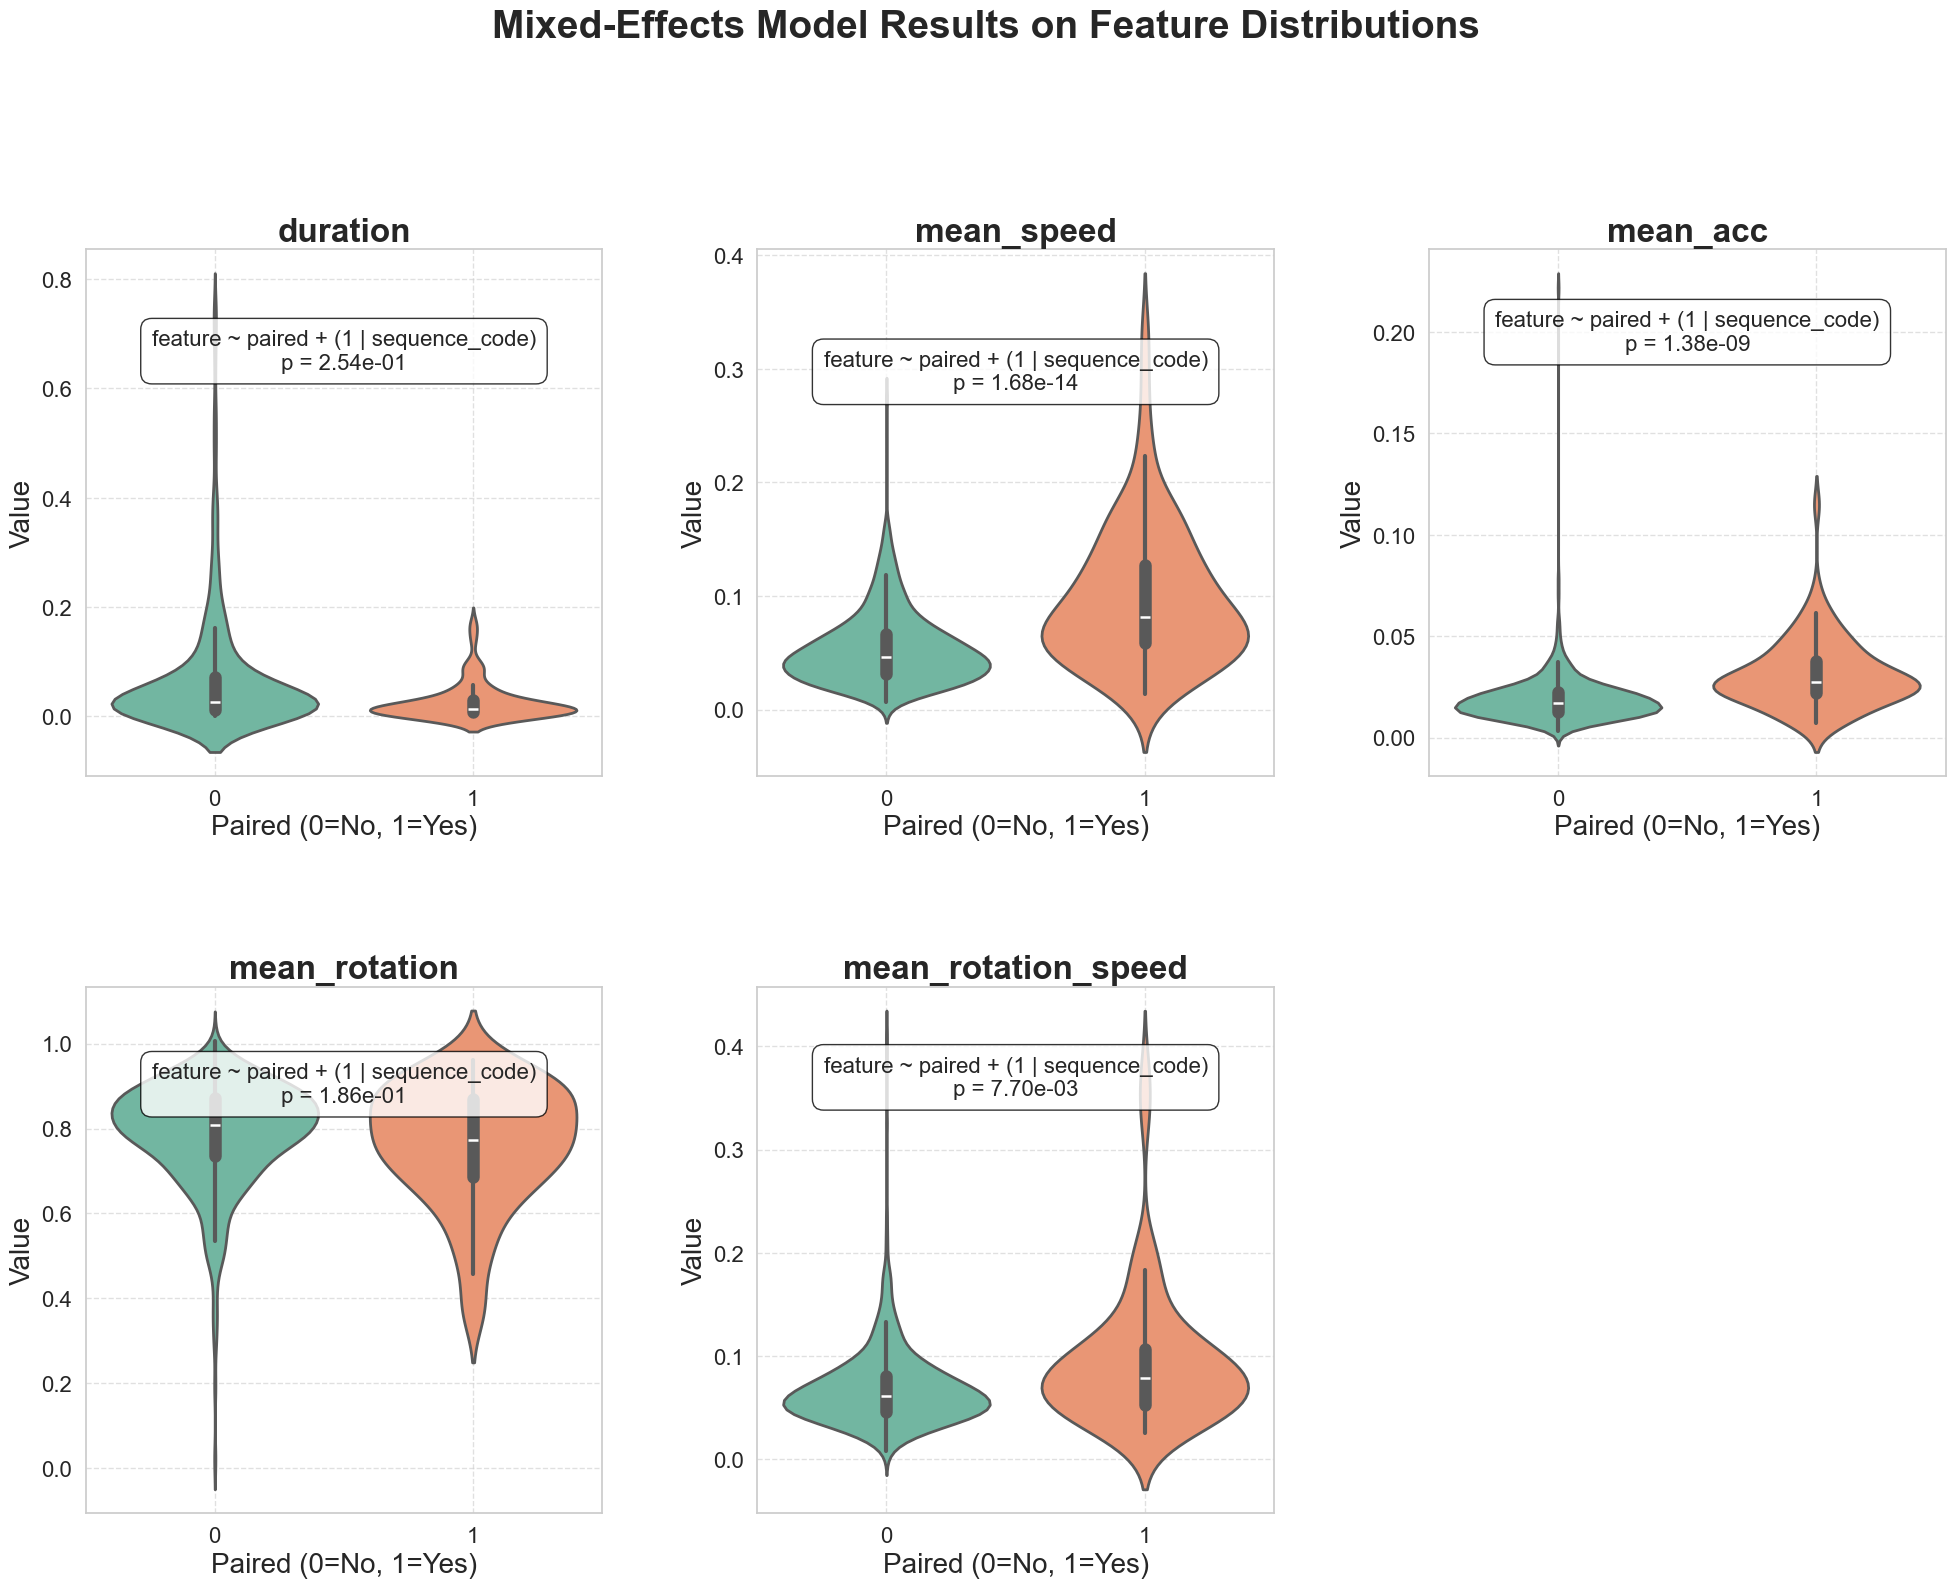

In [20]:

# Set global style and font scale for big presentations
sns.set(style="whitegrid", font_scale=2)

# Initialize figure with large size
plt.figure(figsize=(24, 16))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)

    # Draw violin plot with hue to avoid deprecation warning
    sns.violinplot(
        data=x_test_violin,
        x='paired',
        y=feature,
        hue='paired',
        palette='Set2',
        density_norm='width',
        inner='box',
        linewidth=2,
        legend=False
    )

    # Set titles and labels in large fonts
    plt.title(f'{feature}', fontsize=24, fontweight='bold')
    plt.xlabel('Paired (0=No, 1=Yes)', fontsize=20)
    plt.ylabel('Value', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add model annotation with larger font
    model_info = mixed_results.get(feature, {})
    model_text = model_info.get('model', 'model failed')
    pval = model_info.get('pval', None)
    annotation = f'{model_text}\np = {pval:.2e}' if pval is not None else f'{model_text}\np = N/A'

    # Put annotation slightly above max y
    y_max = x_test_violin[feature].max()
    plt.text(
        0.5,
        y_max * 0.95,
        annotation,
        ha='center',
        va='top',
        fontsize=16,
        bbox=dict(facecolor='white', edgecolor='black', alpha=0.8, boxstyle='round,pad=0.5')
    )

# Super title
plt.suptitle('Mixed-Effects Model Results on Feature Distributions', fontsize=28, fontweight='bold', y=1.05)

# Fix layout
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.3)

plt.show()


| Check the feature distributions between the training and testing datasets

- Kolmogorov-Smirnov(KS)test: non-parametric test, doesn't require a specific distribution, is used to assess the similarity between two probability distribution, and whether samples are from the same distribution

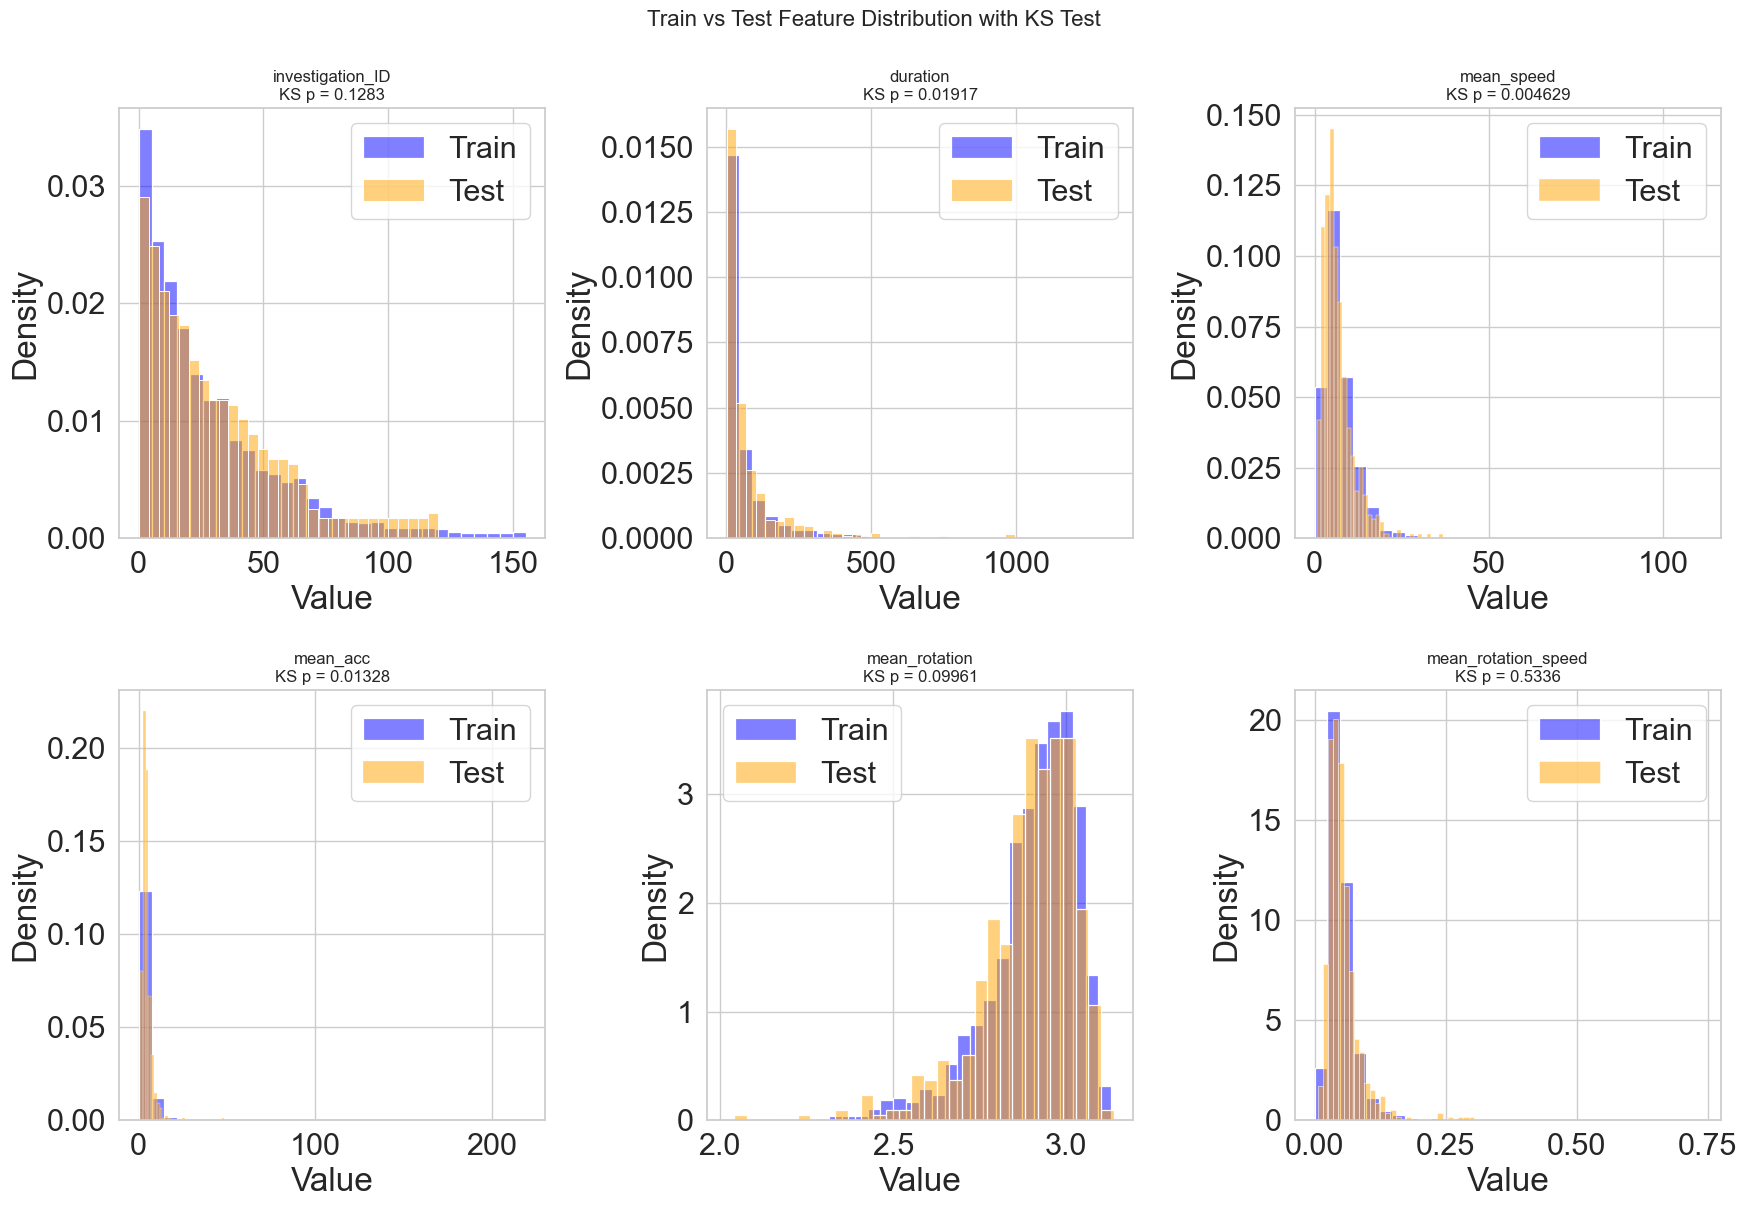

In [51]:

features = ['investigation_ID', 'duration', 'mean_speed', 'mean_acc', 'mean_rotation', 'mean_rotation_speed']

plt.figure(figsize=(18, 12))

for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)

    # Plot histograms
    sns.histplot(x_train[feature], color='blue', label='Train', stat='density', bins=30, alpha=0.5)
    sns.histplot(x_test[feature], color='orange', label='Test', stat='density', bins=30, alpha=0.5)

    # Perform KS test
    stat, pval = ks_2samp(x_train[feature], x_test[feature])

    # Annotate with KS test result
    plt.title(f"{feature}\nKS p = {pval:.4g}", fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.suptitle('Train vs Test Feature Distribution with KS Test', fontsize=16, y=1.02)
plt.show()


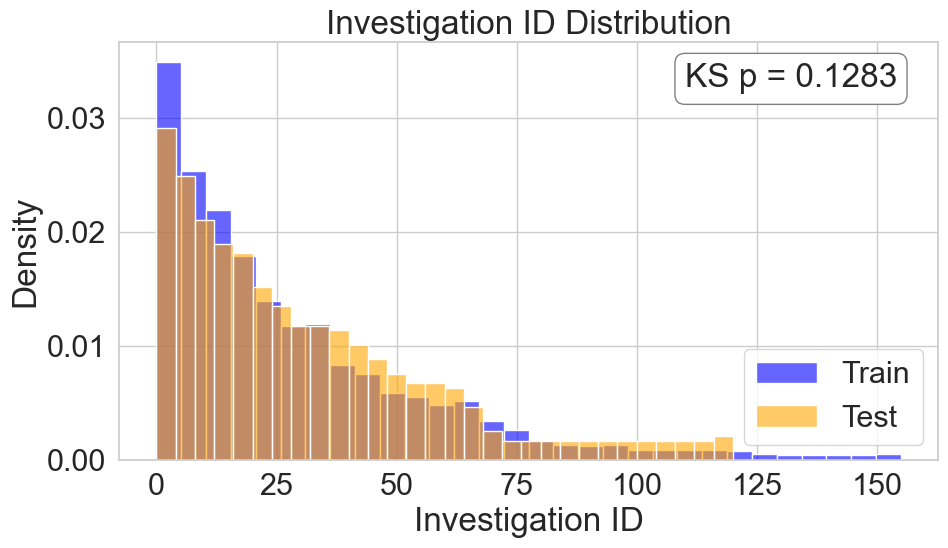

In [36]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_train['investigation_ID'], color='blue', label='Train', bins=30, kde=False, stat='density', alpha=0.6)
sns.histplot(df_test['investigation_ID'], color='orange', label='Test', bins=30, kde=False, stat='density', alpha=0.6)

# KS test
ks_stat, ks_p = ks_2samp(df_train['investigation_ID'], df_test['investigation_ID'])

# Annotate
plt.text(0.95, 0.95, f"KS p = {ks_p:.4f}", transform=plt.gca().transAxes,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle="round", facecolor="white", edgecolor="gray"))

plt.title("Investigation ID Distribution")
plt.xlabel("Investigation ID")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


| Apply MinMaxScaler to normalize the features

In [11]:
#normalize the features to avoid the learned weight bias
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test) #remember to fit the same transformation to the test datset

In [12]:
# Convert back to DataFrames
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns).reset_index(drop=True)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns).reset_index(drop=True)#drop the index column

### Step 3: Apply logistic regression

In [23]:
#before applying the model, drop the investigation_ID and sequence_code
non_related = ['investigation_ID', 'sequence_code','index']
x_train_scaled_final = x_train_scaled.copy(deep=True)
x_test_scaled_final = x_test_scaled.copy(deep=True)
x_train_scaled_final = x_train_scaled_final.drop(columns = non_related)
x_test_scaled_final = x_test_scaled_final.drop(columns = non_related)

In [24]:
#apply the logistic regression
# Logistic Regression with GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 10),  # Inverse of regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs'],  # Suitable for L2, saga for l1
    'max_iter': [1000]
}

logreg = LogisticRegression()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) #use this to preserve the percentages of paired or not paired samples are comparable

grid_search = GridSearchCV(logreg, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(x_train_scaled_final, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 166.81005372000558, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


### Step 4: Evaluate the model


Test Accuracy: 0.8786
F1 Score: 0.2340
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93       511
           1       0.92      0.13      0.23        82

    accuracy                           0.88       593
   macro avg       0.90      0.57      0.58       593
weighted avg       0.88      0.88      0.84       593



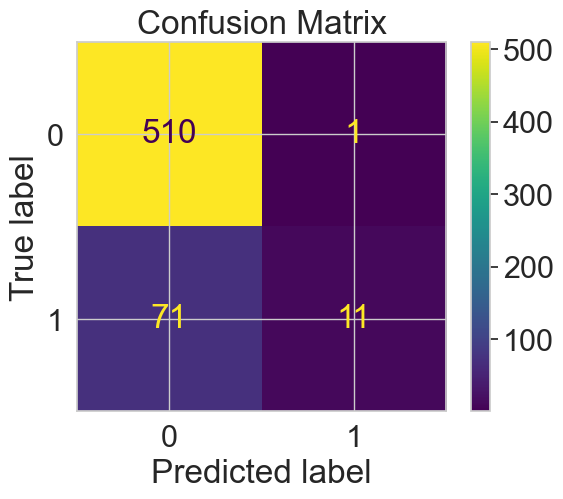

In [25]:
# Predict on test set
y_pred = best_model.predict(x_test_scaled_final)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Full report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, x_test_scaled_final, y_test)
plt.title("Confusion Matrix")
plt.show()


C:\Users\sky\AppData\Local\Temp\ipykernel_30464\2324027629.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Weight', y='Feature', data=coef_df, palette='vlag')


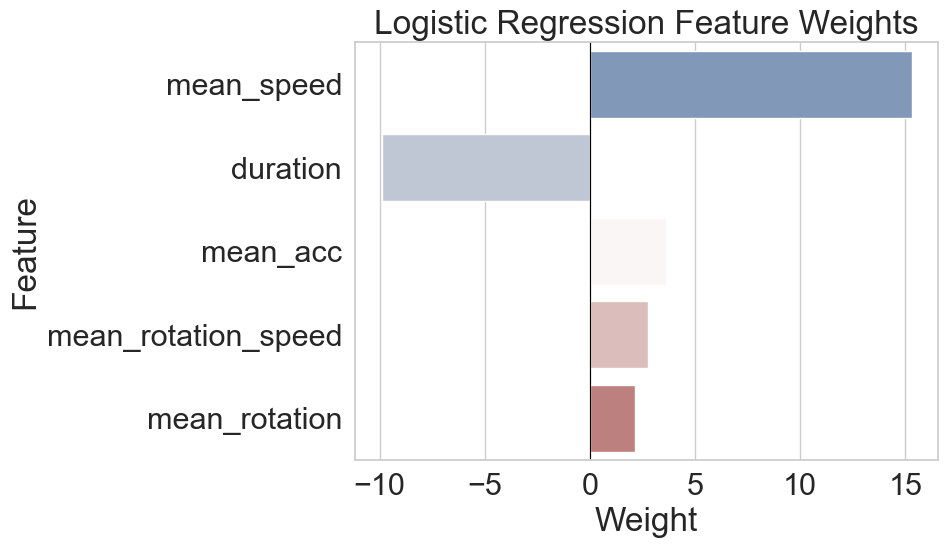

In [26]:
#visualize the coefficient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names
feature_names = x_train_scaled_final.columns

# Get model coefficients (for binary classification, this is 1D)
coefs = best_model.coef_[0]

# Create a DataFrame for better plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Weight': coefs
}).sort_values(by='Weight', key=abs, ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Weight', y='Feature', data=coef_df, palette='vlag')
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Logistic Regression Feature Weights')
plt.tight_layout()
plt.show()


In [ ]:
# visualize the separation between feature pairs


Test Accuracy: 0.8297
F1 Score: 0.3129
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90       511
           1       0.35      0.28      0.31        82

    accuracy                           0.83       593
   macro avg       0.62      0.60      0.61       593
weighted avg       0.81      0.83      0.82       593



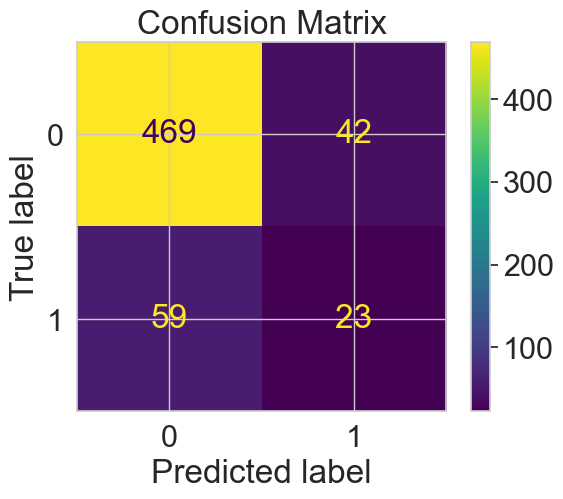

In [29]:
#try randomforest
tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train_scaled_final,y_train)
# Predict on test set
y_tree_pred = tree.predict(x_test_scaled_final)

# Accuracy
acc = accuracy_score(y_test, y_tree_pred)
print(f"Test Accuracy: {acc:.4f}")

# F1 Score
f1 = f1_score(y_test, y_tree_pred)
print(f"F1 Score: {f1:.4f}")

# Full report
print("Classification Report:\n", classification_report(y_test, y_tree_pred))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(tree, x_test_scaled_final, y_test)
plt.title("Confusion Matrix")
plt.show()


### Conclusion


1. The accuracy for the paired investigation is not high, so the model learns larger weights to predict the non-paired investigation

In [27]:
#future direction: random forest